# Final Assignment

In this assignment, you will build a relation extraction model for scientific articles based on the [ScienceIE dataset](https://scienceie.github.io/) in a group of up to 3 students. This is the same dataset that was used for Assignment 2, where you had to train a model to extract keyphrases. You are welcome to build on code any team member already wrote for Assignment 2.

You will build and train relation extraction models on the ScienceIE dataset. For this, you will also need to do data preprocessing to convert the ScienceIE data into a format suitable for training a relation extraction models. 

Your mark will depend on:

* your **reasoning behind modelling choices** made
* the correct **implementations** of your relation extraction models, and
* the **performance** of your models on a held-out test set.

To develop your model you have access to:

* The data in `data/scienceie/`. Remember to un-tar the data.tar.gz file.
* Libraries on the [docker image](https://cloud.docker.com/repository/docker/bjerva/stat-nlp-book) which contains everything in [this image](https://github.com/jupyter/docker-stacks/tree/master/scipy-notebook), including scikit-learn, torch 1.2.0 and tensorflow 1.14.0. 


As with the previous assignment, since we have to run the notebooks of all students, and because writing efficient code is important, your notebook should run in 10 minutes at most, including package loading time, on your machine.
Furthermore, you are welcome to provide a saved version of your model with loading code. In this case loading, testing, and evaluation has to be done in 10 minutes. You can use the dev set to check if this is the case, and assume that it will be fine for the held-out test set if so.

## Setup Instructions
It is important that this file is placed in the **correct directory**. It will not run otherwise. The correct directory is

    DIRECTORY_OF_YOUR_BOOK/assignments/2019/final_assignment/problem/
    
where `DIRECTORY_OF_YOUR_BOOK` is a placeholder for the directory you downloaded the book to. After you placed it there, **rename the file** to your UCPH ID (of the form `xxxxxx`). 

## General Instructions
This notebook will be used by you to provide your solution, and by us to both assess your solution and enter your marks. It contains three types of sections:

1. **Setup** Sections: these sections set up code and resources for assessment. **Do not edit these**. 
2. **Assessment** Sections: these sections are used for both evaluating the output of your code, and for markers to enter their marks. **Do not edit these**. 
3. **Task** Sections: these sections require your solutions. They may contain stub code, and you are expected to edit this code. For free text answers simply edit the markdown field.  

Note that you are free to **create additional notebook cells** within a task section. 

**Do not share** this assignment publicly, by uploading it online, emailing it to friends etc. 

**Do not** copy code from the Web or from other students, this will count as plagiarism.

## Submission Instructions

To submit your solution:

* Make sure that your solution is fully contained in this notebook. 
* **Rename this notebook to your UCPH ID** (of the form "xxxxxx"), if you have not already done so.
* Download the notebook in Jupyter via *File -> Download as -> Notebook (.ipynb)*.
* Upload the notebook to Absalon.


## <font color='green'>Setup 1</font>: Load Libraries
This cell loads libraries important for evaluation and assessment of your model. **Do not change it.**

In [42]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#! SETUP 1
import sys, os
_snlp_book_dir = "../../../../"
sys.path.append(_snlp_book_dir) 
import math
from glob import glob
from os.path import isfile, join
from statnlpbook.vocab import Vocab
from statnlpbook.scienceie import calculateMeasures
import shutil
import string

## <font color='blue'>Task 1</font>: Convert dataset between standoff and IOB format

We want to work with [the ScienceIE dataset](https://scienceie.github.io) that can be found in the `data/scienceie/` directory of the repository.  This dataset comes with **standoff annotation** for keyphrases and relations between them.  This means that for each document in the dataset, there are two files: a `.txt` file with the raw sentences, and a `.ann` file with the annotated keyphrases.  

For example, this is one of the `.txt` files from the training set:

```
Failure of structural components is a major concern in the nuclear power industry and represents not only a safety issue, but also a hazard to economic performance. Stress corrosion cracking (SCC), and especially intergranular stress corrosion cracking (IGSCC), have proved to be a significant potential cause of failures in the nuclear industry in materials such as Alloy 600 (74% Ni, 16% Cr and 8% Fe) and stainless steels, especially in Pressurised Water Reactors (PWR) [1–5]. Stress corrosion cracking in pressurized water reactors (PWSCC) occurs in Alloy 600 in safety critical components, such as steam generator tubes, heater sleeves, pressurized instrument penetrations and control rod drive mechanisms [2,6,7]. Understanding the mechanisms that control SCC in this alloy will allow for continued extensions of life in current plant as well as safer designs of future nuclear reactors.
```

And this is the corresponding `.ann` file:

```
T1	Material 11 32	structural components
T2	Process 0 32	Failure of structural components
T3	Process 254 259	IGSCC
T4	Process 213 252	intergranular stress corrosion cracking
*	Synonym-of T4 T3
T5	Process 165 190	Stress corrosion cracking
T6	Process 192 195	SCC
*	Synonym-of T5 T6
T7	Material 367 376	Alloy 600
T8	Material 378 402	74% Ni, 16% Cr and 8% Fe
*	Synonym-of T7 T8
T9	Material 408 424	stainless steels
T10	Material 440 466	Pressurised Water Reactors
T11	Material 468 471	PWR
T12	Process 480 505	Stress corrosion cracking
T13	Material 509 535	pressurized water reactors
T14	Material 537 542	PWSCC
*	Synonym-of T13 T14
T15	Material 554 563	Alloy 600
T16	Material 603 624	steam generator tubes
T17	Material 626 640	heater sleeves
T18	Material 642 677	pressurized instrument penetrations
T19	Material 682 710	control rod drive mechanisms
T20	Material 762 765	SCC
T21	Material 774 779	alloy
T22	Material 835 840	plant
T23	Task 852 892	safer designs of future nuclear reactors
T24	Material 876 892	nuclear reactors
T25	Material 567 593	safety critical components
R1	Hyponym-of Arg1:T16 Arg2:T25	
R2	Hyponym-of Arg1:T17 Arg2:T25	
R3	Hyponym-of Arg1:T18 Arg2:T25	
R4	Hyponym-of Arg1:T19 Arg2:T25
```

Note: Besides keyphrases, which you are already familiar with from Assignment 2, the `.ann` files also contain relation annotations labeled `Hyponym-of` and `Synonym-of`. These are relations between keyphrases. 

`Synonym-of` is an undirected relation, meaning that if you see a line like this:

```*	Synonym-of T13 T14```

The order of keyphrases could be swapped, i.e. the following would also hold:

```*	Synonym-of T14 T13```

The evaluation script will thus be agnostic to the order in which the keyphrases between which `Synonym-of` relations hold are ordered.

`Hyponym-of`, on the other hand, is a directed relation, meaning that it is order-sensitive, and that the evaluation script will take the order of keyphrases between which `Hyponym-of` relations hold into account.

The `.ann` standoff format is **documented in [the brat documentation](http://brat.nlplab.org/standoff.html).**  
You may want to convert the format into some internal representation for training models; however, how you do that is up to you, i.e. you do not have to use IOB format like in Assignment 2. 

**Further Notes**:
- At training time, you you will be provided with plain text documents and `.ann` files with keyphrases and relations
- At test time, you will be provided with plain text documents and `.ann` files **with keyphrases only**. This is because your task is to predict relations.
- The evaluation script is agnostic to the order of relation triples and relation ids, but should preserve the ids of the keyphrases that will be used in the predicted relations. The evaluation scripts requres the entity annotations to be present as well in the prediction file.

### Module imports

To highlight the important parts of the assignmen, most of the functions are written in modules in 'Extra_files/modules'. These are imported below.

In [62]:
### General modules
import pprint
from gensim.models import fasttext
from gensim.models import KeyedVectors
from copy import deepcopy
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pp = pprint.PrettyPrinter(compact = True).pprint

### Our own modules
from Extra_files.modules.load_and_save import load_scienceie, save_to_ann, reformat_to_save
from Extra_files.modules.rules import _add_rules
from Extra_files.modules.error_analysis import plot_confusion_matrix, get_dataframe, plot_correct_labels
from Extra_files.modules.DataPreparation import entityLocator, addPOStoDic, addLemmatoDic, inputPair, WordEmbedder
from Extra_files.modules.MasterVocab import MasterVocab
from Extra_files.modules.scaling import downscale, upscale
from Extra_files.models.dummy_model import _sebastians_dummy_model

### Load Sciencie

The 'load_scienceie' converts the dataset from standoff to IOB format.<br>
Due to overlapping sentences, some of the entities must be removed, and this also results in loss of relations. The exact numbers are printed. 

After having converted it to IOB-format, it removes references ([13],[14-16], etc.). These are defined as brackets with only integers, or the symbols '-', '-' or komma in.

It also concatenates 'i.e.' and 'e.g.' to a single words. These are extensively used between hyponyms, and it is believed that it will be easier for the CNN implemented below to detect the importance of 'i.e.' than 'i', '.', 'e', '.'.

In [10]:
print("Loading dev_data...")
dev_data = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "dev"))
print("Loading train_data...")
train_data = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "train"))

Loading dev_data...
Number of entities removed due to overlap: 269 out of 1330
Number of entities not identified in text: 1 out of 1061
Number of relations lost due to overlap: 10 out of 168
Removed references.
Concatenated 'i.e.' and 'e.g.'.
Loading train_data...
Number of entities removed due to overlap: 1337 out of 7405
Number of entities not identified in text: 28 out of 6068
Number of relations lost due to overlap: 50 out of 673
Removed references.
Concatenated 'i.e.' and 'e.g.'.


### Spacy

We will use Spacy's model 'en' for POS-tagging and lemmatizations later. This therefore has to be downloaded:

In [11]:
!python -m spacy download en
import spacy
nlp = spacy.load("en")
nlp.tokenizer = nlp.tokenizer.tokens_from_list

You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/lib/python3.6/site-packages/en_core_web_sm -->
/opt/conda/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [12]:
engbedder = WordEmbedder()
engbedder.loadModel()

### Reshape IOBtags to traindata for model

In [13]:
### Den endelige funktion til at generere data_X og data_Y
def dataX_Y_format(data, nlp_language = nlp, maxvocab = 4092, indices = False, engbedder_bool=False):
    """
    This takes the raw data from 'load_scienceie' and converts data_X and data_Y for input to tensorflow.
    
    Input:
        data: The raw data output from 'load_scienceie' (a dictionary)
        
        indices: If False, it returns the names in the features (word, type-of-entity, POS). 
                 If True, it converts word, type-of-entity and POS to indices, which can be used for embedding.
                 
    Output:
        data_X, data_Y
        
        data_X is a list of 2d np-array with shape (sentence_length, feature_length)
        data_Y is a 1d np-array
    """
    
    vocab = MasterVocab(max_vocab_size = maxvocab)
    print("Creating X and Y..")
    if indices or engbedder_bool:
        #vocab_w, vocab_ent, vocab_pos = GenerateVocabs(data, maxvocab, nlp)
        vocab.generateVocabularies(data, nlp_language)
    
    metadata = []
    data_X = []
    data_Y = []
        
    for txt, file in data.items():
        addPOStoDic(file, nlp_language)
        addLemmatoDic(file, nlp_language)
        entities = entityLocator(file)
        
        #Labels
        labels = {}
        labels['Synonyms']= [(rel[2],rel[3]) for rel in file['relations'] if rel[1] == 'Synonym']
        labels['Hyponyms'] = [(rel[2],rel[3]) for rel in file['relations'] if rel[1] == 'Hyponym']
        
        # create a 'stair' of combinations
        
        for i in range(len(entities)):
            for j in range(i+1, len(entities)):
                
                #Extrac X and annotation names
                ann_names = (entities[i][0],entities[j][0])
                ann_names_reverted = (entities[j][0],entities[i][0])
                
                xdata = inputPair(entities[i], entities[j], file, nlp_language)
                
                metadata.append( (txt,entities[i][0],entities[j][0]) )
                
                #Reformat X
                if indices or engbedder_bool:
#                     xout = vocab.transformX_toIndex(xdata)
                    if engbedder_bool:
                        xout = vocab.transformX_toEmbeddings(xdata, engbedder)
                    else:
                        xout = vocab.transformX_toIndex(xdata)
                    data_X.append(np.array(xout))
                else:
                    data_X.append(np.array(xdata))
                
                ### Extract label
                if ann_names in labels['Hyponyms']:
                    data_Y.append('Hyponym')
                elif ann_names_reverted in labels['Hyponyms']:
                    data_Y.append('Hyponym_reverted')
                elif ann_names in labels['Synonyms'] or ann_names_reverted in labels['Synonyms']:
                    data_Y.append('Synonym')
                else:
                    data_Y.append('NONE')
                    

    #We need it all in a single object
    data = {'metadata': metadata, 'data_X': data_X, 'data_Y': data_Y, 'Vocab': vocab}
    
    ### Downscaling:
    print("Downscaling data..")
    if indices:
        data = downscale(data, vocab.word_vocab)
    else:
        data = downscale(data)
    
    print('The 4 labels after downscaling:')
    pp(Counter(data['data_Y']).most_common())
    
    return data

#### Reshaping tokens and IOBtags to train data

In [14]:
from pickle import load, dump

# data_m_XY = dataX_Y_format(train_data,indices = True) 
# data_m_XY_dev = dataX_Y_format(dev_data,indices = True)
# dump(data_m_XY, open('Extra_files/resources/train_ind.pkl', 'wb'))

data_m_XY = load(open('Extra_files/resources/train_ind.pkl', 'rb'))
data_m_XY_dev = load(open('Extra_files/resources/dev_ind.pkl', 'rb'))
train_keys = set(train_data.keys())
dev_keys = set(dev_data.keys())

if False:
    print(data_m_XY['metadata'][0])
    pp(data_m_XY['data_X'][0])
    print(data_m_XY['data_Y'][0])
    
    print(data_m_XY['Vocab'].transformX_toLabel(data_m_XY['data_X'][0]))

In [15]:
data_m_XY2 = upscale(data_m_XY, 10)


Upscaling relations with factor 10
Labels before scale: [('NONE', 18412), ('Hyponym_reverted', 256), ('Synonym', 226), ('Hyponym', 137)]
Labels after scale: [('NONE', 18412), ('Hyponym_reverted', 2560), ('Synonym', 2260), ('Hyponym', 1370)]


In [16]:
def cached_data_format(data, *args, **kwargs):
    if set(data.keys())== train_keys:
        return data_m_XY
    elif set(data.keys())== dev_keys:
        return data_m_XY_dev
    else:
        return dataX_Y_format(data, *args, **kwargs)

#### Downscaling and upscaling
I will plot the distribution of labels before downscaling, upscaling, and after...

In [ ]:
# x = cached_data_format(train_data)  # should happen instantly

In [17]:
train_X = data_m_XY2['data_X']
train_Y = data_m_XY2['data_Y']

In [18]:
dev_X = data_m_XY_dev['data_X']
dev_Y = data_m_XY_dev['data_Y']

In [19]:
## MW - QUICK MODEL - NEEDED GLOBAL VARIABLES 

# DON'T TOUCH, WILL BE MOVED / CLEANED

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
### NfS
enc.fit(np.asarray(data_m_XY['data_Y']).reshape(-1,1))
# enc.fit(np.asarray(['Hyponym', 'Hyponym_reverted', 'NONE', 'Synonym']).reshape(-1,1))
###

def gen(xs, ys=None, once=False):
    """
    Catch all function:
        makes data trainable/predictable by yielding batches of single observations, i.e.
        compatable with the input of the NN
    """
    def to_col_list(sequence):
        return [np.expand_dims(x,0) if i not in [1,2] else np.expand_dims(np.expand_dims(x,-1),0) for i, x in enumerate(list(np.swapaxes(sequence, 1,0)))]
    def onehot(y):
        return enc.transform(np.array(y).reshape(-1,1)).todense()

    if ys is not None:
        while True:
            for x,y in zip(xs, ys):
                yield to_col_list(x), onehot(y)
            if once:
                break
    else:
        while True:
            for x in xs:
                yield to_col_list(x)
            if once:
                break
        
# onehot(train_Y[0]).todense()
    
# for x,y in gen(train_X, train_Y):
#     print(x)
#     print(y.todense())
#     break

# for x,y in gen(train_X, train_Y):
    
#     print(enc.inverse_transform(m.predict(x))[0])
#     break

## <font color='blue'>Task 1.1</font>: Develop and Train a Relation Extraction Model with Gold Keyphrases

In this task, you develop a relation extraction model and apply it to the ScienceIE dataset.
As input to it, at test time, you will have the plain input texts as well as `.ann` files containing gold (i.e. correct) keyphrase annotations. The output should be `.ann` files containing relations between those keyphrases (you should include the keyphrase annotations in the output file as well).

A test input/output example is given in folders `data/scienceie/test/`,`data/scienceie/test_pred/`.

There are no strict requirements for how to design this model. You are expected to use the knowledge you have gathered throughout this course to design and implement this model. 

You are welcome to re-use existing code you might have written for other assignments as you see fit.

You are free to implement your solution in either PyTorch or Tensorflow, but if you are not sure where to start, we recommend looking at the [Keras API](https://keras.io) which is [integrated into Tensorflow 1.14.0](https://www.tensorflow.org/beta/guide/keras/overview?hl=en).

In [26]:
# You should improve this cell
from Extra_files.modules.Dynamic_pooling import Dynamic_max_pooling
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Conv1D, Lambda, Flatten, Reshape
from tensorflow.keras.losses import categorical_crossentropy  # , sparse_categorical_crossentropy

def create_model(train_data, dev_data):
    """
    Return an instance of a relation extraction model defined over the dataset.
    Args:
        train_data: the training data the relation extraction detection model should be defined over.
        dev_data: the development data the relation extraction detection model can be tuned on.
    Returns:
        a relation extraction model
    """
    ## PARAMETERS
    
    # Embeddings
    vocab_size = 4092
    entity_vocab_size = 20
    pos_vocab_size = 20
    
    word_emb_dim = 50
    entity_emb_dim = 10
    pos_emb_dim = 10
     
    # Conv1D
    filters = 20
    conv_kernel_size = 1
    conv_strides = 1
    
    # Pooling
    dyn_out_len = 10
    
    ## LAYERS
    
    # Input
    tokens = Input(batch_shape=(1, None))
    relpos1 = Input(batch_shape=(1, None, 1))
    relpos2 = Input(batch_shape=(1, None, 1))
    entity = Input(batch_shape=(1, None))
    pos = Input(batch_shape=(1, None))
    lemma = Input(batch_shape=(1, None))
    
    # Embedding
    word_emb = Embedding(vocab_size, word_emb_dim)(tokens)
    entity_emb = Embedding(entity_vocab_size, entity_emb_dim)(entity)
    pos_emb = Embedding(pos_vocab_size, pos_emb_dim)(pos)
    lemma_emb = Embedding(vocab_size, word_emb_dim)(lemma)
    
    # Base-model
    x = concatenate([word_emb, relpos1, relpos2, entity_emb, pos_emb, lemma_emb], axis=2)
    x = Conv1D(filters=filters, kernel_size=conv_kernel_size, strides=conv_strides, activation='relu')(x)
    x = Dynamic_max_pooling(filters, dyn_out_len)(x)
    x = Flatten()(x)
    x = Dense(4, activation='softmax')(x)  # 4 == n_classes in data (i.e. NOT a parameter)
    
    ## Create model
    model = Model(inputs=[tokens, relpos1, relpos2, entity, pos, lemma], outputs=x)
#     model.summary()

    model.compile(loss=categorical_crossentropy,  # for onehot, for idx: sparse_categorical_crossentropy
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


def train_model(model, train_data, dev_data):
    """Train a relation extraction model on the given dataset.
    Args:
        model: The model to train
        data_train: The dataset to train on
        dev_data: the development data the relation extraction detection model can be tuned on
    """
    
    ### Reformat with Skjøtt's functions
#     data_m_XY_train = dataX_Y_format(train_data,indices = True)
#     data_m_XY_dev = dataX_Y_format(dev_data,indices = True)
    
    ### Extract X and Y
#     train_X = data_m_XY_train['data_X']
#     train_Y = data_m_XY_train['data_Y']
#     dev_X = data_m_XY_dev['data_X']
#     dev_Y = data_m_XY_dev['data_Y']
    
    #### TENSORFLOW MODEL (BEGIN) ------------------------------------------
    
    ## PARAMETERS
    epochs = 5
    
    model.fit_generator(gen(train_X, train_Y), steps_per_epoch=len(train_X), epochs=epochs)
    #### TENSORFLOW MODEL (END) --------------------------------------------
    
    return

def make_predictions(model, data, return_raw = False):
    """Makes predictions on a list of instances
    Args:
        model: The trained model
        data: The dataset to evaluate on
    Returns:
        The model's predictions for the data.
        If 'return_raw = True, it returns 'data_dict' (see below), else it returns reformatted data ready for saving.
    """
    
    ### Reformat and extract 'data_X'
#     data_m_XY = dataX_Y_format(data,indices = True)
#     data_X = data_m_XY['data_X']   
    local_data_m_XY = deepcopy(data_m_XY_dev)       
    #### TENSORFLOW MODEL (BEGIN) ------------------------------------------
    
#     predictions = data_m_XY['data_Y'] #The perfect model, this works
    #predictions = _sebastians_dummy_model(data_m_XY, data)
    predictions = []
    for x in gen(dev_X, None, True):
#     for x in gen(train_X, None, True):
        predictions.append(model.predict(x))
    predictions = list(np.squeeze(enc.inverse_transform(np.squeeze(np.asarray(predictions)))))

    #### TENSORFLOW MODEL (END) --------------------------------------------
    
    
    #local_data_m_XY = _add_rules(local_data_m_XY,data)
    ### Save in correct format
    local_data_m_XY['data_Y'] = predictions
    if return_raw:
        return local_data_m_XY
    else:
        #data = deepcopy(data)   ##### DOES NOT WORK ATM - USING GLOBAL VARS
        save_format = reformat_to_save(local_data_m_XY)
        for txt in data:
            data[txt]['relations'] = save_format.get(txt,[]) #We might have txt's with no data after downscaling

        return data


In [ ]:
# Create model
model = create_model(train_data, dev_data)
train_model(model, train_data, dev_data)


           precision   recall f1-score  support

    Hyponym     0.00     0.00     0.00       47
    Synonym     0.00     0.00     0.00       43
Hyponym_reverted     0.07     0.21     0.11       67

avg / total     0.07     0.09     0.08      157




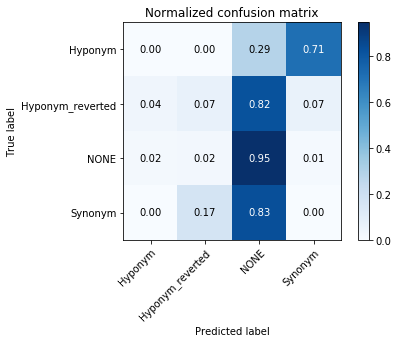

In [48]:
## THIS CELL TESTS THAT EVERYTHING WORKS AS EXPECTED (WITH F1-SCORE COPIED FROM CALCULATE-MEASURES) #####
from Extra_files.modules.helpers import f1_score_ala_calc_measures

#Make predictions
y_base = make_predictions(model, dev_data, return_raw = True)['data_Y']
y_true = dev_Y

#Plot
f1_score_ala_calc_measures(y_true, y_base)
plot_confusion_matrix(y_base, y_true, n_labels=None,normalize=True)
plt.show()

In [ ]:
## This runs the correct calculateMeasures (which might not work yet due to illegal relations) #####
#Load data
dir_dev = join(_snlp_book_dir, "data", "scienceie", "dev")
data_dev = load_scienceie(datadir=dir_dev)

#Make predictions
data_pred = make_predictions(_, data_dev)
dir_pred = join(_snlp_book_dir, "data", "scienceie", "dev_pred")

#Save and calculate
save_to_ann(data_pred, dir_pred)
calculateMeasures(dir_dev, dir_pred, "keys") # this will only evaluate the correctness of relations


In [ ]:
# DO NOT MODIFY THIS CELL! It will evaluate your model on an unseen dataset!
shutil.rmtree(join(_snlp_book_dir, "data", "scienceie", "test_pred")) # clean after previous

data_train = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "train"))
data_dev = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "dev"))

model = create_model(data_train, data_dev)
train_model(model, data_train, data_dev)

data_test = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "test"))
data_pred = make_predictions(model, data_test)
dir_pred = join(_snlp_book_dir, "data", "scienceie", "test_pred")
save_to_ann(data_pred, dir_pred)

dir_gold = join(_snlp_book_dir, "data", "scienceie", "test_gold")
calculateMeasures(dir_gold, dir_pred, "keys") # this will only evaluate the correctness of relations

## <font color='red'>Assessment 1.1</font>: Correctness of the implementation (20 pts)

We assess if your code implements a correct relation extraction model (10 points):

* 0-5 pts: the model does not run correctly or does not constitute a relation extraction model
* 5-10 pts: the model correctly implements the requirements

Additionally, we will assess how well your model performs on an unseen test set (10 points):

* 0-5 pts: performance worse than a simple baseline model
* 5-10 pts: performance better than a simple baseline model

## <font color='blue'>Task 1.2</font>: Describe your Approach

Enter a maximum 500 words description of your model developed in Task 1.1, its architecture, and the way you trained and tuned it. Motivate your choices, describing potential benefits and downsides.

## <font color='red'>Assessment 1.2</font>: Modelling Choices and Motivation (10 pts)


Finally, we assess your modelling design choices and how you motivated them, which you summarised in the above cell (10 points):

* 0-5 pts: the model design choices do not show high levels of creativity, e.g. re-using code from the lecture out of the box; and they are not moviated well
* 5-10 pts: the model design choices show high levels of creativity, e.g. combining different things learned throughout the course, models inspired by further reading, etc.; and they are motivated well

## <font color='blue'>Task 2</font>: Relation Extraction with Weak Supervision

In this task, the goal is to improve the performance of your model developed in Task 2 by obtaining more automatically labelled training data using a weak supervision approach. You are not required to change the relation extraction model architure, i.e. it is fine to re-use the one from Task 1, but instead, the requirements are to implement one or more weak supervision strategies.

Some possible weak supervision methods for relation extraction will be introduced in the lecture Week 43 (https://github.com/copenlu/stat-nlp-book/blob/master/chapters/relation_extraction_slides.ipynb); the following blog post also serves as a good introduction to this topic: https://hazyresearch.github.io/snorkel/blog/ws_blog_post.html

For this task, you are not confined to the training data provided to you, but you are welcome to obtain additional unlabelled datasets and automatically label them using weak supervision methods. 

The general setup will otherwise be the same as for Task 1:
As input to it, you will have the plain input texts as well as `.ann` files containing gold (i.e. correct) keyphrase annotations. The output should be `.ann` files containing relations between those keyphrases.

**Important notes**:
- You must provide code for the functions below. 
- If running them on the full dataset exceeds the 10 minute limit, you are welcome to additionally provide a line of code that (down)loads the already weakly annotated data.
- The maximum file size for weakly annotated data may not exceed 1GB.

A test input/output example is given in folders `data/scienceie/test/`,`data/scienceie/test_pred/`.

In [49]:
## Load Hypernyms from UMLS
from Extra_files.modules.UMLS import add_UMLS

#data_m_XY = add_UMLS(data_m_XY)

In [55]:
# You should improve this cell

def create_weak_model(train_data, dev_data, **args):
    """
    Return an instance of a relation extraction model defined over the dataset.
    Args:
        train_data: the training data the relation extraction detection model should be defined over.
        dev_data: the development data the relation extraction detection model can be tuned on.
        **args: any additional arguments needed, e.g. additional automatically labelled training data
    Returns:
        a relation extraction model
    """
    return model #Comes from previous problem

def train_weak_model(model, train_data, dev_data, **args):
    """Train a relation extraction model on the given dataset.
    Args:
        model: The model to train
        data_train: The dataset to train on
        dev_data: the development data the relation extraction detection model can be tuned on
        **args: any additional arguments needed, e.g. additional automatically labelled training data
    """
    pass

def make_predictions_weak(model, data, return_raw = False):
    """Makes predictions on a list of instances. Can be the same as function developed in Task 1.
    Args:
        model: The trained model
        data: The dataset to evaluate on
    Returns:
        The model's predictions for the data.
    """
    
    local_data_m_XY = make_predictions(model,data,return_raw = True)
    local_data_m_XY = _add_rules(local_data_m_XY,data)
    
    if return_raw == True:
        return local_data_m_XY  
    else:
        save_format = reformat_to_save(local_data_m_XY)
        for txt in data:
            data[txt]['relations'] = save_format.get(txt,[]) #We might have txt's with no data after downscaling
        return data



Number of forced synonyms: 30
Number of removed synonyms: 1
Number of removed hyponym-relations within list: 18
Number of labels changed to hyponyms: 20
Number of labels that would be changed but already in list of hyponyms: 19
           precision   recall f1-score  support

    Hyponym     0.00     0.00     0.00       47
    Synonym     0.74     0.60     0.67       43
Hyponym_reverted     0.08     0.24     0.12       67

avg / total     0.18     0.27     0.22      157




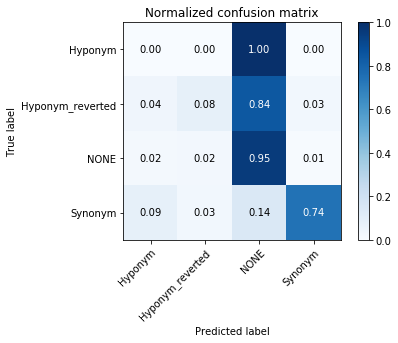

In [56]:
## THIS CELL TESTS THAT EVERYTHING WORKS AS EXPECTED (WITH F1-SCORE COPIED FROM CALCULATE-MEASURES) #####
from Extra_files.modules.helpers import f1_score_ala_calc_measures

#Make predictions
y_weak = make_predictions_weak(model, dev_data, return_raw = True)['data_Y']
y_true = dev_Y

#Plot
f1_score_ala_calc_measures(y_true, y_weak)
plot_confusion_matrix(y_weak, y_true, n_labels=None,normalize=True)
plt.show()

In [ ]:
# Training a model and evaluating it on the development set. 
# Use this to monitor the performance of your model prior to submitting your assignment.
data_train = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "train"))
dir_dev = join(_snlp_book_dir, "data", "scienceie", "dev")
data_dev = load_scienceie(datadir=dir_dev)

model = create_weak_model(data_train, [data_dev])
train_weak_model(model, data_train, data_dev)

data_pred = make_predictions_weak(model, data_dev)
dir_pred = join(_snlp_book_dir, "data", "scienceie", "dev_pred")
save_to_ann(data_pred, dir_pred)

calculateMeasures(dir_dev, dir_pred, "keys") 

In [ ]:
# DO NOT MODIFY THIS CELL! It will evaluate your model on an unseen dataset!
shutil.rmtree(join(_snlp_book_dir, "data", "scienceie", "test_pred")) # clean after previous

data_train = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "train"))
data_dev = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "dev"))

model = create_weak_model(data_train, data_dev)
train_weak_model(model, data_train, data_dev)

data_test = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "test"))
data_pred = make_predictions_weak(model, data_test)
dir_pred = join(_snlp_book_dir, "data", "scienceie", "test_pred")
save_to_ann(data_pred, dir_pred)

dir_gold = join(_snlp_book_dir, "data", "scienceie", "test_gold")
calculateMeasures(dir_gold, dir_pred, "keys") # this will only evaluate the correctness of relations

In [ ]:
dir_pred = join(_snlp_book_dir, "data", "scienceie", "test_pred")
dir_gold = join(_snlp_book_dir, "data", "scienceie", "test_gold")

dir_gold = join(_snlp_book_dir, "data", "scienceie", "test_gold")
calculateMeasures(dir_gold, dir_pred, "keys") # this will only evaluate the correctness of relations

## <font color='red'>Assessment 2.1</font>: Correctness of the implementation (20 pts)

We assess if your code implements correct weak supervision methods (10 points):

* 0-5 pts: the model does not run correctly or the methods implemented do not constitute weak supervision strategies
* 5-10 pts: the model correctly implements the requirements

Additionally, we will assess how well your model performs on an unseen test set (10 points):

* 0-5 pts: performance worse than a simple baseline model
* 5-10 pts: performance better than a simple baseline model

## <font color='blue'>Task 2.2</font>: Describe your Approach

Enter a maximum 500 words description of your weak supervision stategies developed in Task 2.1 and the way you trained and tuned them. Motivate your choices, describing potential benefits and downsides.

## <font color='red'>Assessment 2.2</font>: Modelling Choices and Motivation (10 pts)


Finally, we assess your modelling design choices and how you motivated them, which you summarised in the above cell (10 points):

* 0-5 pts: the model design choices do not show high levels of creativity, e.g. re-using code from the lecture out of the box; and they are not moviated well
* 5-10 pts: the model design choices show high levels of creativity, e.g. combining different things learned throughout the course, models inspired by further reading, etc.; and they are motivated well

## <font color='blue'>Task 3</font>: Comparison of relation extraction models

Reflect on the models implemented in Tasks 1 and 2. What worked and didn't work well, and how would you explain this? How and when does the performance differ between the models and why might that be? You are expected to perform a small error analysis on the development set in order to answer these questions.

In [57]:
# DataFrame for later use
df_err_an = get_dataframe(dev_data, data_m_XY_dev, y_true, y_base, y_weak)

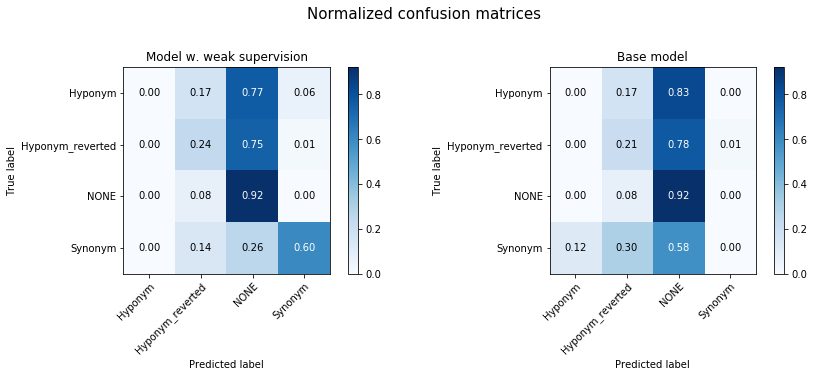

In [60]:
# Confusion matrix
import seaborn as sns
sns.reset_orig() #seaborn changes matplotlib default settings. 

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,3.8))

fig.suptitle('Normalized confusion matrices',y=1.1,fontsize = 15)
ax1 = plot_confusion_matrix(y_true, y_weak, n_labels=None,normalize=True,ax = ax1)
ax1.set(title = 'Model w. weak supervision')
ax2 = plot_confusion_matrix(y_true, y_base, n_labels=None,normalize=True, ax = ax2)
ax2.set(title = 'Base model')
plt.show()

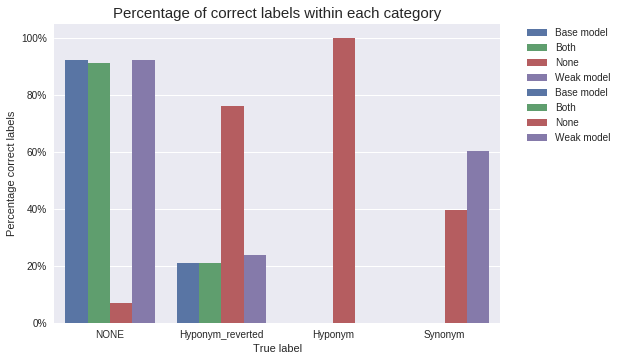

In [64]:
### Plot seaborn with labels
_ = plot_correct_labels(df_err_an)
plt.show()

## <font color='red'>Assessment 3</font>: Assess your explanation (20 pts)

We will mark the explanation along the following dimension: 

* Substance (20pts: well-designed error analysis, correctly explained reasons for performance differences between models)